# Task 3 - Deliveries Confirmed

In [1]:
# Load necessay packages
import pandas as pd 
import seaborn as sb
import numpy as np

In [2]:
def load_and_clean_data(excel_path):
    results_db = {}
    excel_dict = pd.read_excel(excel_path, sheet_name=None)
    file_names = list(excel_dict.keys())
    # This is actually what I wanted to do in the first place but for some reason my debugger was really bad, and I couldn't find why I wasn't able to interate with the dict.values.
    # And I didn't have much time - busy week, sorry :/ 
    ##### excel_dict = pd.read_excel(excel_path, sheet_name=None)
    ##### file_names = list(excel_dict.keys())
    ##### file_values = list(excel_dict.values())
    ##### for file_name in file_names:
    #####    for file_value in file_values:
    for file_name in file_names:
        file_value = pd.read_excel(excel_path, sheet_name=file_name)
        # Data Preparation 
        # Retrive supplier names
        supplier_names = file_value['TOTAL'].dropna().tolist()
        supplier_names.remove('SUM')
        # Retrieve production Backlog
        production_backlog = file_value['Unnamed: 3'][0]
        stock_at_hand = file_value['Unnamed: 3'][1]
        # Remove unecessary columns 
        file_value.drop(file_value.columns[[0,1,2,3]], inplace=True, axis=1)
        # Transpose table
        file_value = file_value.T.reset_index(drop=True)
        # Get when the supply rows starts being 0 
        for column_number in np.arange(1,len(file_value.columns)):
            inital_row = file_value[column_number].astype(float).sum() != 0
            if inital_row == False:
                break
        # Drop columns 
        file_value.drop(np.arange(column_number,len(file_value.columns)), inplace=True, axis=1)
        # Rename columns
        column_names = ['Date', 'Date_Code', 'Demand']
        column_names.extend(supplier_names)
        file_value.columns = column_names
        # Create Column Confirm Deliveries
        file_value['confirmed_deliveres'] = file_value[supplier_names].sum(axis=1)
        # Create column material balance
        file_value['material_balance'] = np.NaN
        # Initial_Value
        file_value['material_balance'][0] = stock_at_hand - production_backlog - file_value['Demand'][0]
        # Generate the rest of the values
        for row_number in np.arange(1, len(file_value)):
            file_value.loc[row_number, 'material_balance'] = file_value.loc[row_number-1, 'confirmed_deliveres'] + file_value.loc[row_number-1, 'material_balance'] - file_value.loc[row_number, 'Demand']
        results_db[file_name] = file_value
    return results_db  

In [3]:
# Generate Data

excel_path = 'https://github.com/yurialmeida5/NK_Component_Analysis/blob/main/Task3/Task_3.xlsx?raw=true'
results = load_and_clean_data(excel_path)


# Generate dataset - How many confirmed deliveries do we have in each supplier in all period? 
not_consider_columns = ['Date', 'Date_Code', 'Demand', 'confirmed_deliveres', 'material_balance']

non_zero_count = []
component_list = []
supplier_list = []
confirm_deliver = pd.DataFrame()

for component in results.keys():
    table_columns = list(set(list(results[component].columns)) - set(not_consider_columns))
    for supplier in table_columns:
        non_zero_count.append(np.count_nonzero(results[component][supplier]))
        component_list.append(component)
        supplier_list.append(supplier)

confirm_deliver['component'] = component_list
confirm_deliver['supplier'] = supplier_list
confirm_deliver['qtd_deliver'] = non_zero_count

C:\Users\Yuri_Almeida\AppData\Local\Temp\ipykernel_21164\1674490098.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_value['material_balance'][0] = stock_at_hand - production_backlog - file_value['Demand'][0]


# Graph Display

<AxesSubplot:xlabel='supplier', ylabel='qtd_deliver'>

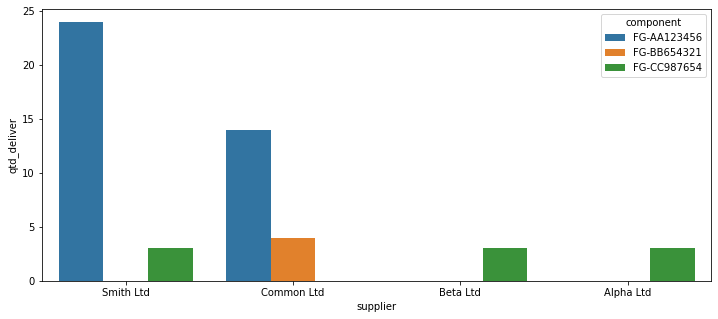

In [4]:
import seaborn as sb
import matplotlib.pyplot as plt
FIGURE_FIGSIZE = (12,5)
fig = plt.subplots(figsize = FIGURE_FIGSIZE)

sb.barplot(data = confirm_deliver, x = 'supplier', y = 'qtd_deliver', hue ='component')